In [1]:
import os

MODELGARDENPATH = '..\\models\\research'
MODEL_DIR = 'models\\my_ssd_model'
PIPELINE_CONFIG_PATH = os.path.join(MODEL_DIR, 'pipeline.config')
LABEL_MAP = 'data\\label_map.pbtxt'


In [2]:
command = os.path.join(MODELGARDENPATH, 'object_detection\\model_main_tf2.py')
command = f'python {command} --pipeline_config_path={PIPELINE_CONFIG_PATH} --model_dir={MODEL_DIR} --alsologtostderr'
command

'python ..\\models\\research\\object_detection\\model_main_tf2.py --pipeline_config_path=models\\my_ssd_model\\pipeline.config --model_dir=models\\my_ssd_model --alsologtostderr'

In [3]:
!{command}

2021-12-02 20:52:04.587649: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-02 20:52:05.583756: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6641 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:2d:00.0, compute capability: 6.1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I1202 20:52:05.591830 13372 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I1202 20:52:05.597833 13372 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Ma

In [11]:
command = os.path.join(MODELGARDENPATH, 'object_detection\\model_main_tf2.py')
command = f'python {command} --pipeline_config_path={PIPELINE_CONFIG_PATH} --checkpoint_dir={MODEL_DIR} --model_dir={MODEL_DIR} --alsologtostderr'
command

'python ..\\models\\research\\object_detection\\model_main_tf2.py --pipeline_config_path=models\\my_ssd_model\\pipeline.config --checkpoint_dir=models\\my_ssd_model --model_dir=models\\my_ssd_model --alsologtostderr'

# Evaluation

In [2]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(MODEL_DIR, 'ckpt-50')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [11]:
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP)
IMAGE_PATH = 'data\\images\\00887.ppm'

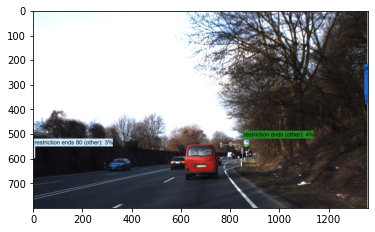

In [19]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

# label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes'],
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=0.03,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()